# VAR 

In [28]:
pip install statsmodels==0.12.2

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [30]:
plt.rcParams['figure.figsize'] = [10, 7.5]

## United States Macroeconomic Dataset 

In [31]:
#macro_data = sm.datasets.macrodata.load_pandas()
#macro_data = macro_data.data
#macro_data.head()

In [32]:
url='https://raw.githubusercontent.com/nzxtdata/Multivariate-Financial-Time-Series-Forecasting-with-Machine-Learning/main/SPXfundamental.csv'
df1 = pd.read_csv(url, parse_dates= True)
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date', inplace=True)

macro_data=df1.copy()
macro_data=macro_data.asfreq('b')
macro_data=macro_data.fillna(method='ffill')
macro_data['returns'] = macro_data.spxclose.pct_change(1).mul(100)
macro_data = macro_data.iloc[1:]
macro_data=macro_data[macro_data.index < '2020-12-01']

In [33]:
#macro_data = macro_data.resample('28D').interpolate()

In [34]:
#macro_data=macro_data.loc['1994-03-31':'2020-02-01']


In [35]:
macro_data['returns'] = macro_data.spxclose.pct_change(1).mul(100)
macro_data = macro_data.iloc[1:]

In [36]:
macro_data

,spxopen,spxhigh,spxlow,spxclose,spxvolume,US_treasury_yield,OPEC/ORB - Value,us_gdp_qoq,us_unemployment_ra_%,us_longterm_ir_%,returns
Date,,,,,,,,,,,
2003-04-02,858.479980,884.570007,858.479980,880.900024,1.589800e+09,1.16,27.22,1.770926,5.866667,3.92,2.611598
2003-04-03,880.900024,885.890015,876.119995,876.450012,1.339500e+09,1.16,27.22,1.770926,5.866667,3.92,-0.505167
2003-04-04,876.450012,882.729980,874.229980,878.849976,1.241200e+09,1.16,27.22,1.770926,5.866667,3.92,0.273828
2003-04-07,878.849976,904.890015,878.849976,879.929993,1.494000e+09,1.16,27.22,1.770926,5.866667,3.92,0.122890
2003-04-08,879.929993,883.109985,874.679993,878.289978,1.235400e+09,1.16,27.22,1.770926,5.866667,3.92,-0.186380
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,3594.520020,3642.310059,3594.520020,3635.409912,6.267570e+09,0.12,40.65,-2.848345,8.800000,0.65,1.616167
2020-11-25,3635.500000,3635.500000,3617.760010,3629.649902,4.902560e+09,0.12,40.65,-2.848345,8.800000,0.65,-0.158442
2020-11-26,3635.500000,3635.500000,3617.760010,3629.649902,4.902560e+09,0.12,40.65,-2.848345,8.800000,0.65,0.000000


Text(0.5, 1.0, 'US Growth Rate')

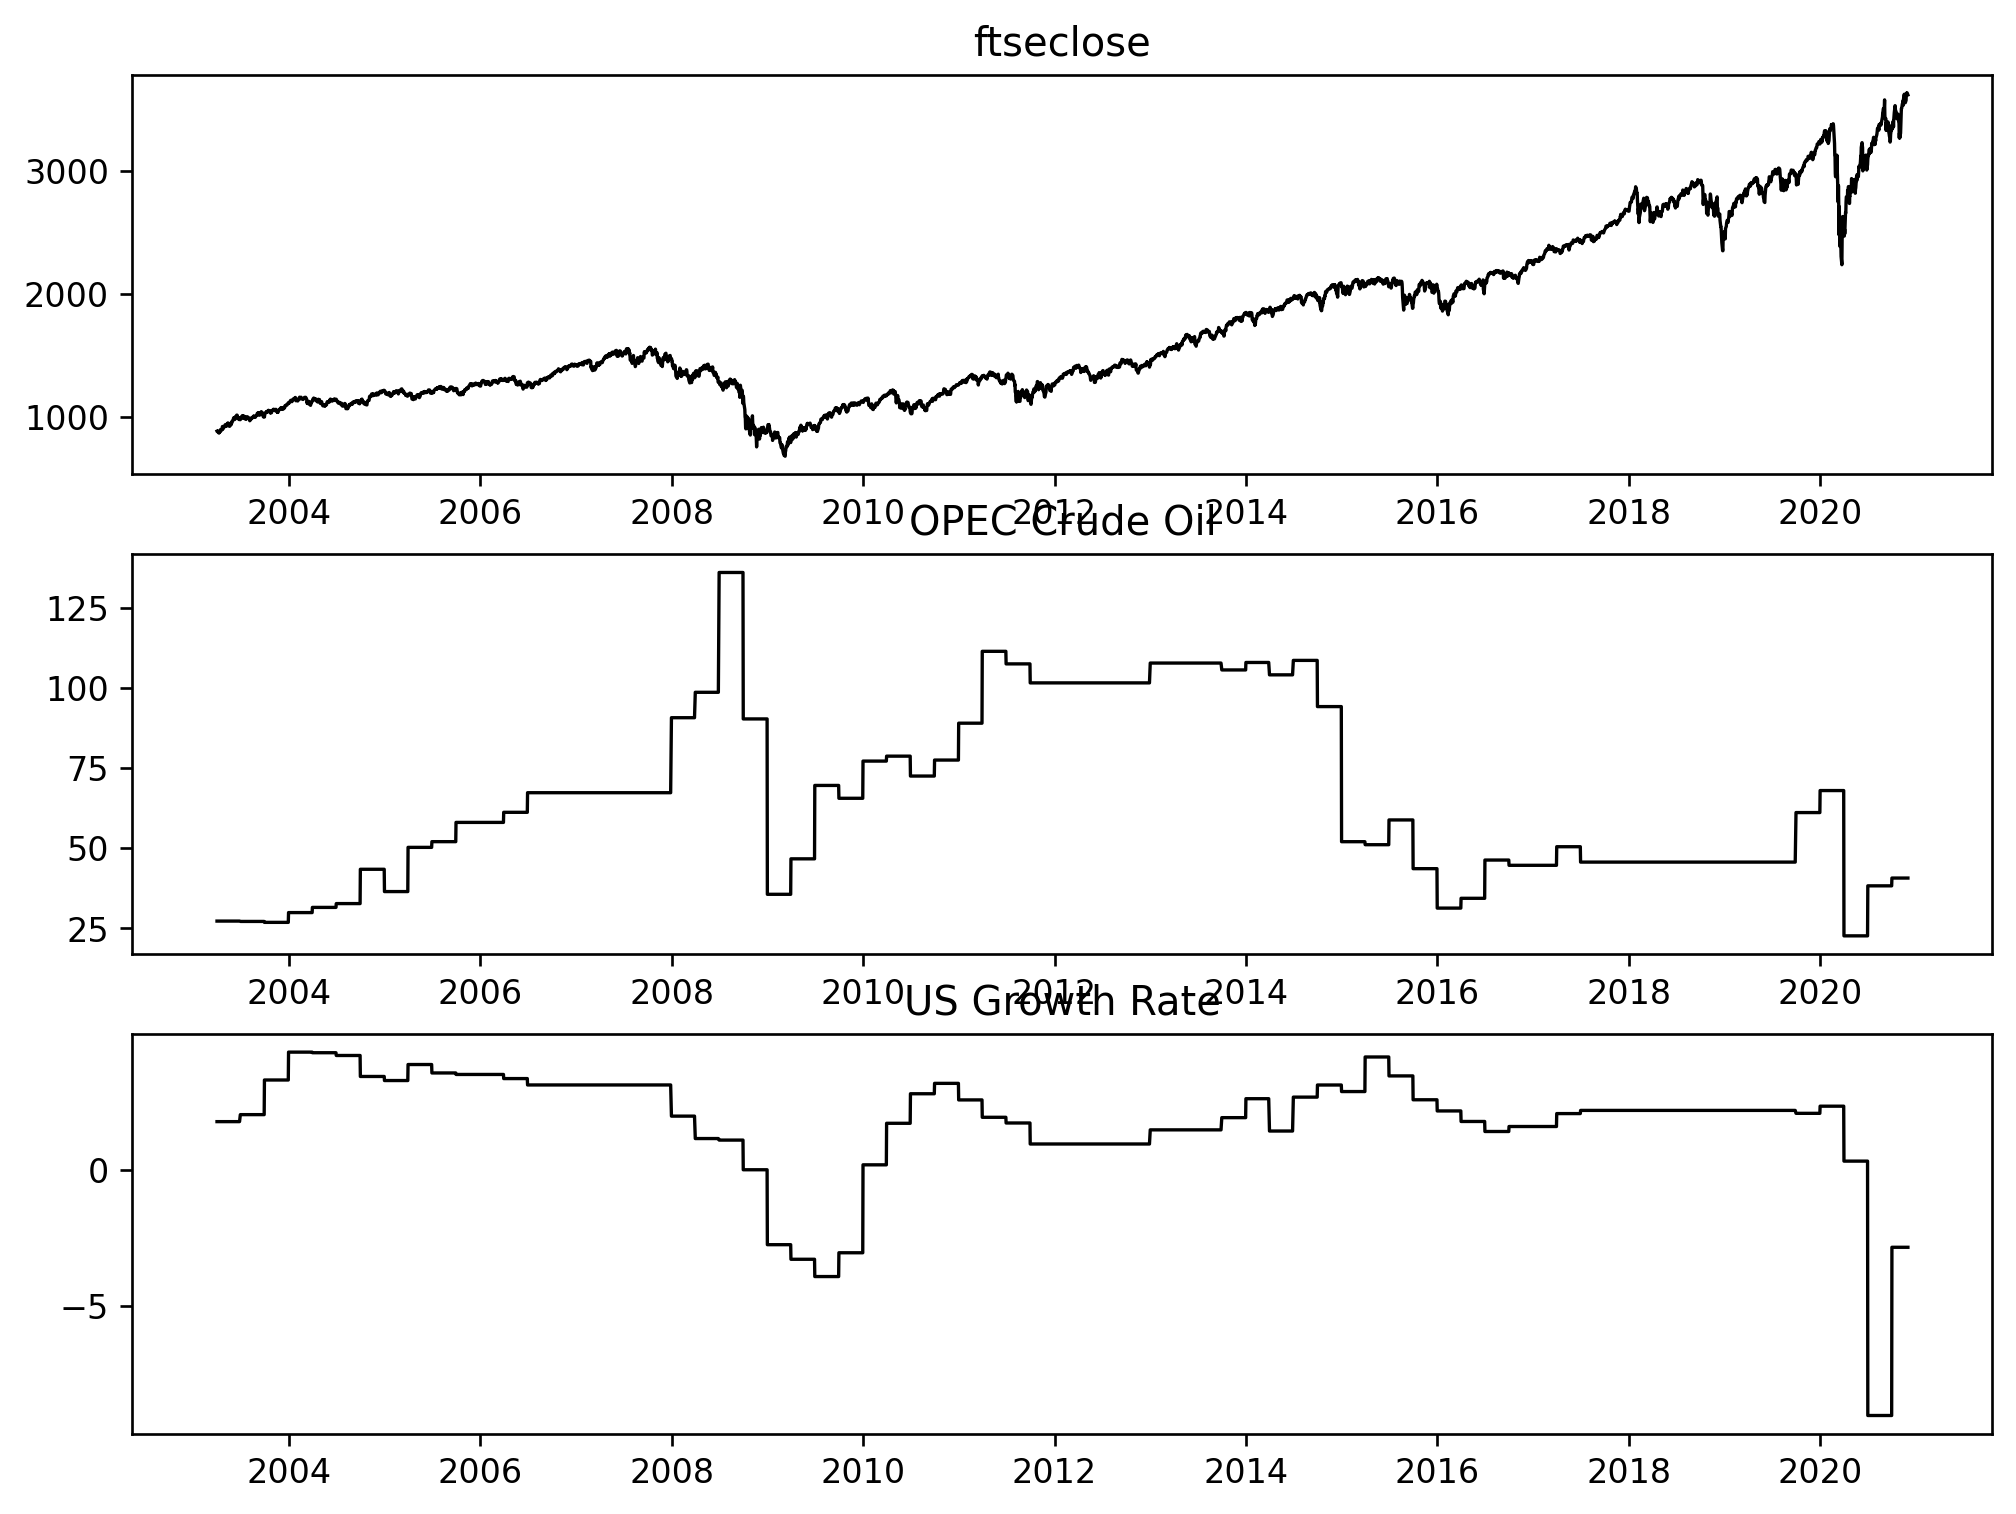

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, dpi=240)

ax1.plot(macro_data['spxclose'], color='black', linewidth=1)
ax1.set_title('ftseclose')
#ax1.xaxis.set_ticks_position('none')
#ax1.yaxis.set_ticks_position('none')
#ax1.spines['top'].set_alpha(0)
#ax1.tick_params(labelsize=6)

ax2.plot(macro_data['OPEC/ORB - Value'], color='black', linewidth=1)
ax2.set_title('OPEC Crude Oil')
#ax2.xaxis.set_ticks_position('none')
#ax2.yaxis.set_ticks_position('none')
#ax2.spines['top'].set_alpha(0)
#ax2.tick_params(labelsize=6)

ax3.plot(macro_data['us_gdp_qoq'], color='black', linewidth=1)
ax3.set_title('US Growth Rate')

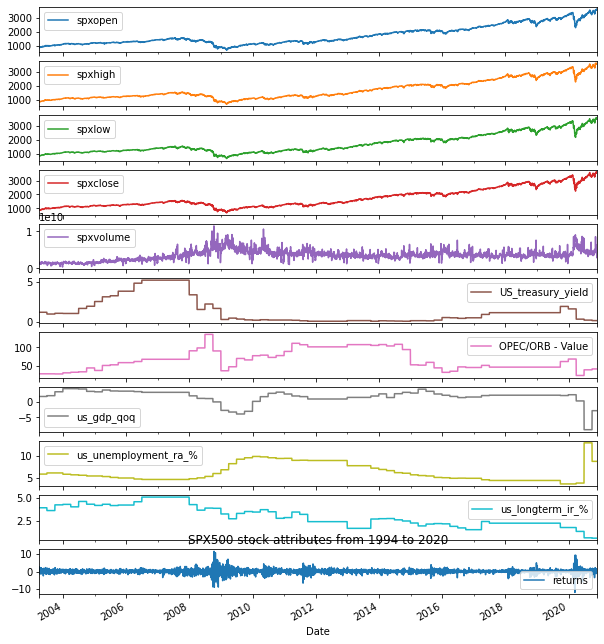

In [38]:
macro_data['1994':'2020'].plot(subplots=True, figsize=(10,12))
plt.title('SPX500 stock attributes from 1994 to 2020')
plt.savefig('stocks.png')
plt.show()

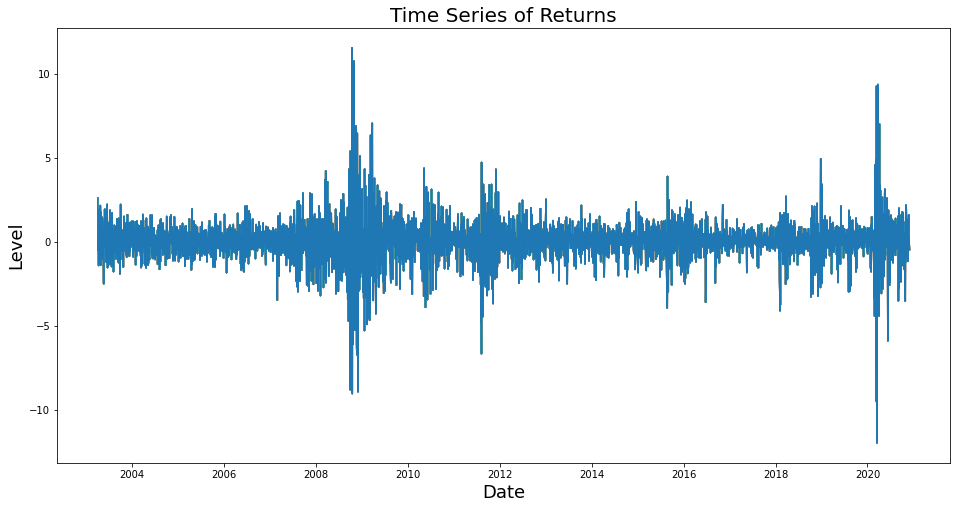

In [39]:
series = list(macro_data.columns)
fig, ax = plt.subplots(figsize = (16,8))
for series in series:
    x = macro_data.index
    y = macro_data['returns']
    ax.plot(x, y, label=series)
ax.legend(fontsize=12)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Level', fontsize=18)
plt.title('Time Series of Returns', fontsize=20)
ax.get_legend().remove()

plt.show()

In [42]:
ad_fuller_result_1 = adfuller(macro_data['spxclose'].diff()[1:])

print('ftseclose')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_data['returns'].diff()[1:])

print('fwd_6mo_usd_to_gbp')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

ftseclose
ADF Statistic: -15.150228595041945
p-value: 6.813763343269369e-28

---------------------

fwd_6mo_usd_to_gbp
ADF Statistic: -21.316072008238095
p-value: 0.0


In [43]:
def optimize_VAR(endog):
    """
        Returns a dataframe with parameters and corresponding MSE
        
        endog - observed time series
    """
    
    results = []
    
    for i in tqdm_notebook(range(6)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue
            
        mse = model.mse
        results.append([i, mse])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'mse']
    
    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)
    
    return result_df

In [44]:
macro_data.columns

Index(['spxopen', 'spxhigh', 'spxlow', 'spxclose', 'spxvolume',
       'US_treasury_yield', 'OPEC/ORB - Value', 'us_gdp_qoq',
       'us_unemployment_ra_%', 'us_longterm_ir_%', 'returns'],
      dtype='object')

[15:34:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


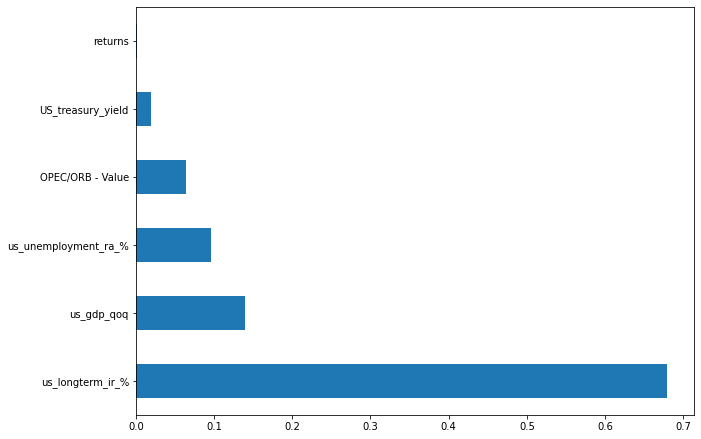

In [45]:
from numpy import loadtxt
from xgboost import XGBRegressor
from matplotlib import pyplot

model = XGBRegressor()
model.fit(macro_data[[ 'US_treasury_yield', 'OPEC/ORB - Value', 'us_gdp_qoq',
       'us_unemployment_ra_%', 'us_longterm_ir_%', 'returns']], macro_data[['spxclose']])

(pd.Series(model.feature_importances_, index=macro_data[['US_treasury_yield', 'OPEC/ORB - Value', 'us_gdp_qoq',
       'us_unemployment_ra_%', 'us_longterm_ir_%', 'returns']].columns)
   .nlargest(7)
   .plot(kind='barh'))

In [46]:
macro_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4609 entries, 2003-04-02 to 2020-11-30
Freq: B
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   spxopen               4609 non-null   float64
 1   spxhigh               4609 non-null   float64
 2   spxlow                4609 non-null   float64
 3   spxclose              4609 non-null   float64
 4   spxvolume             4609 non-null   float64
 5   US_treasury_yield     4609 non-null   float64
 6   OPEC/ORB - Value      4609 non-null   float64
 7   us_gdp_qoq            4609 non-null   float64
 8   us_unemployment_ra_%  4609 non-null   float64
 9   us_longterm_ir_%      4609 non-null   float64
 10  returns               4609 non-null   float64
dtypes: float64(11)
memory usage: 592.1 KB


In [47]:
macro_data.describe()

,spxopen,spxhigh,spxlow,spxclose,spxvolume,US_treasury_yield,OPEC/ORB - Value,us_gdp_qoq,us_unemployment_ra_%,us_longterm_ir_%,returns
count,4609.000000,4609.000000,4609.000000,4609.000000,4.609000e+03,4609.000000,4609.000000,4609.000000,4609.000000,4609.000000,4609.000000
mean,1730.035360,1739.499241,1719.921007,1730.378673,3.504313e+09,1.281590,65.419638,1.787453,6.266385,3.022510,0.038332
std,681.363289,683.740584,678.410310,681.245881,1.384042e+09,1.571174,27.623800,2.128398,2.037591,1.116284,1.189551
min,679.280029,695.270020,666.789978,676.530029,3.560700e+08,0.040000,22.610000,-9.032775,3.600000,0.650000,-11.984055
25%,1198.109985,1205.089966,1191.089966,1198.410034,2.690270e+09,0.120000,45.630000,1.425725,4.633333,2.263333,-0.373604
50%,1433.560059,1440.859985,1427.390015,1433.369995,3.469730e+09,0.500000,58.790000,2.183861,5.433333,2.736667,0.046835
75%,2122.270020,2128.909912,2112.860107,2124.199951,4.144310e+09,1.640000,90.700000,3.119473,7.800000,4.020000,0.526167
max,3638.550049,3645.989990,3629.330078,3638.350098,1.145623e+10,5.170000,136.030000,4.326363,13.066667,5.070000,11.580037


In [48]:
endog = macro_data[['spxclose', 'spxlow', 'US_treasury_yield', 'OPEC/ORB - Value', 'us_gdp_qoq',
       'us_unemployment_ra_%', 'us_longterm_ir_%', 'returns']]

In [49]:


result_df = optimize_VAR(endog)
result_df

,p,mse
0,5,65971.936531
1,4,70513.365235
2,3,70745.756778
3,2,71749.177152
4,1,77494.562883


In [50]:
best_model = VARMAX(endog, order=(5,0))
res = best_model.fit(disp=False)
print(res.summary())

                                                                                    Statespace Model Results                                                                                    
Dep. Variable:     ['spxclose', 'spxlow', 'US_treasury_yield', 'OPEC/ORB - Value', 'us_gdp_qoq', 'us_unemployment_ra_%', 'us_longterm_ir_%', 'returns']   No. Observations:                 4609
Model:                                                                                                                                           VAR(5)   Log Likelihood             -449556.420
                                                                                                                                            + intercept   AIC                         899840.840
Date:                                                                                                                                  Thu, 29 Jul 2021   BIC                         902183.459
Time:                              

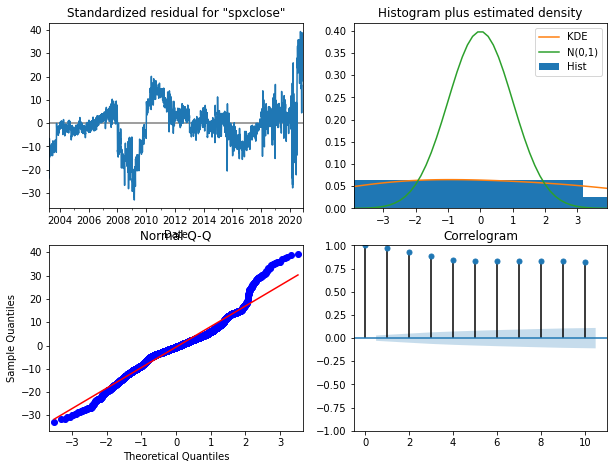

In [51]:
res.plot_diagnostics();

In [52]:
n_forecast = 30
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

predict.predicted_mean.tail(3)

,spxclose,spxlow,US_treasury_yield,OPEC/ORB - Value,us_gdp_qoq,us_unemployment_ra_%,us_longterm_ir_%,returns
2021-01-08,2725.000732,2727.273434,1.056977,50.688766,-1.471479,5.867754,5.525061,-5.937182
2021-01-11,2705.733151,2708.134857,1.058849,50.923037,-1.404063,5.884418,5.500489,-5.942371
2021-01-12,2692.232781,2694.221695,1.055442,51.211608,-1.358401,5.887835,5.447194,-5.805445


In [53]:
macro_data.shape

(4609, 11)

In [54]:
macro_date_show = macro_data[macro_data.index >= '2020-11-01']
true_vals = df1[(df1.index >= '2020-12-01') & (df1.index < '2021-01-01')]

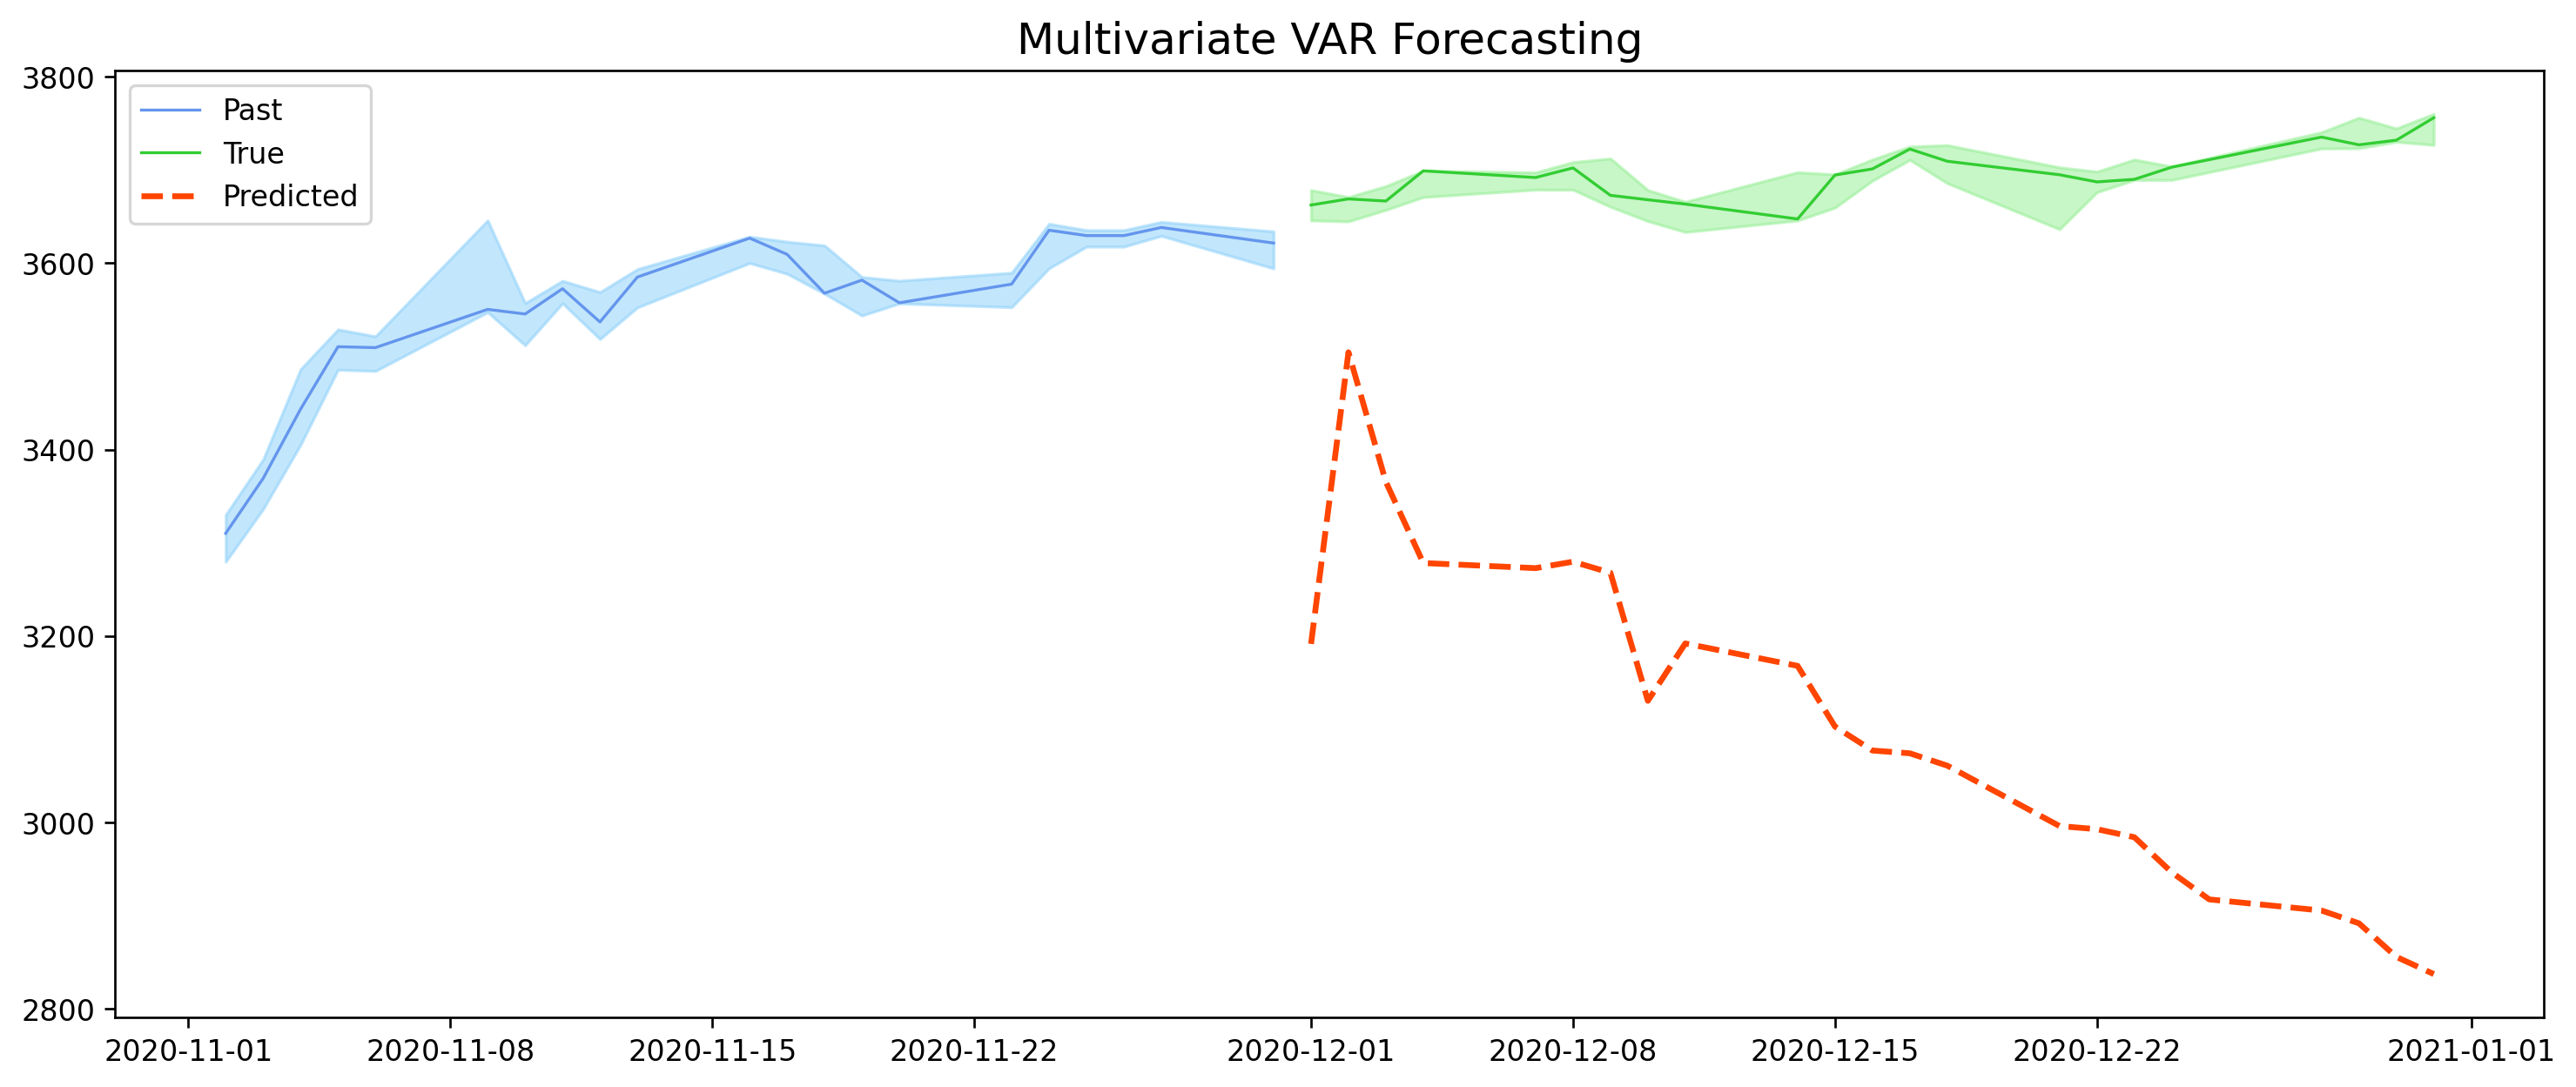

In [55]:
fig, ax1 = plt.subplots(dpi=240,figsize=(15,6))

ax1.plot(macro_date_show['spxclose'], color='cornflowerblue', linewidth=1, label='Past')
ax1.plot(true_vals['spxclose'], color='limegreen', linewidth=1, label='True')


ax1.plot(predict.predicted_mean.index[-31:-8], 
         predict.predicted_mean['spxclose'][-31:-8], 
         color='orangered', 
         ls='--',
         linewidth=2, label='Predicted')

ax1.fill_between(macro_date_show.index, macro_date_show.spxlow, macro_date_show.spxhigh, color='lightskyblue', alpha=0.5)
ax1.fill_between(true_vals.index, true_vals.spxlow, true_vals.spxhigh, color='lightgreen', alpha=0.5)

ax1.set_title("Multivariate VAR Forecasting", size = 15)
ax1.legend()

plt.show()

In [56]:
test_df = true_vals.resample('D').mean()[['spxclose']]
test_df['preds'] = predict.predicted_mean[['spxclose']][-31:-8].resample('D').mean().values

test_df = test_df.dropna()

In [57]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [58]:
timeseries_evaluation_metrics_func(test_df.spxclose, test_df.preds)

Evaluation metric results:-
MSE is : 381594.7099446785
MAE is : 587.2906208458667
RMSE is : 617.7335266477597
MAPE is : 15.864836128442711
R2 is : -524.1277449693691

